In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Carregamento de bibliotecas

In [2]:
from sklearn.svm import SVC
from sklearn.utils import shuffle
from time import time as tick
import numpy as np
import imageio as iio
import math
from joblib import dump, load
from IPython.display import clear_output

### Programa

#### Carregamento de imagens de treino e de teste

In [3]:
dir_training = 'DRIVE/training/images/'
dir_test = 'DRIVE/test/images/'
dir_sol1_test = 'DRIVE/test/1st_manual/'
dir_sol2_test = 'DRIVE/test/2nd_manual/'
dir_mask_training = 'DRIVE/training/new_mask/'
dir_mask_test = 'DRIVE/test/new_mask/'
dir_sol_training = 'DRIVE/training/1st_manual/'

N = 20
training = []
sol_training = []
masks_training = []
test = []
sol1_test = []
sol2_test = []
mask_test = []

for i in range(N):
    
    #training images and masks
    training.append(255-iio.imread(dir_training + str(20+i+1)+'_training.tif')[:,:,1].astype(np.float64))
    #training.append(255-iio.imread(dir_training + str(20+i+1)+'_training.tif')[:,:,1])
    sol_training.append(iio.imread(dir_sol_training + str(20+i+1)+'_manual1.gif'))
    masks_training.append(iio.imread(dir_mask_training + str(20+i+1)+'_training_mask.gif'))
    
    #test images and masks
    if i<9:
        pre = '0'
    else:
        pre = ''
    test.append(255-iio.imread(dir_test + pre +str(i+1)+'_test.tif')[:,:,1].astype(np.float64))
    sol1_test.append(iio.imread(dir_sol1_test + pre  + str(i+1)+'_manual1.gif'))
    sol2_test.append(iio.imread(dir_sol2_test + pre  + str(i+1)+'_manual2.gif'))
    mask_test.append(iio.imread(dir_mask_test + pre +str(i+1)+'_test_mask.gif'))
    
    #plot some images to check
    #if i%5 ==0:
    #    plt.imshow(mask_test[i], cmap = 'gray')
    #    plt.figure()


#### Determinação dos parâmetros das imagens:  line strength, orthogonal line strength e intensidade (x = [S, So, I])

Função que determina as 12 retas cuja inclinação incrementa de 15 graus. Devolve uma matriz 12x15x2 com as coordenadas dos pontos da reta. Faz o mesmo para as respetivas 12 linhas ortogonais de 3 pontos devolvendo uma matriz 12x3x2.

In [4]:
def lines_opt(l = 15, c = 15, centerx = 7, centery = 7, deg_step = 15, n_steps = 12):
    #returns coordinates of the pixels in a 15x15 window correspondent to the lines calculated
    
    lines = np.zeros((l, c), int) 
    lines_plot = np.zeros((n_steps, l, c), int) 
    lines_coord = np.zeros((n_steps, l, 2), int)
    lines_ort_plot = np.zeros((n_steps, l, c), int) 
    lines_ort_coord = np.zeros((n_steps, 3, 2), int)
    
    for i in range(n_steps):
        for j in range(c):
            #evaluate value of funciton y = slope*x where x is the pixel count within the center pixel(0,0)
            j_ = j
            j_ort = j
            
            if deg_step*i<=45 or deg_step*i>=135:
                slope = tan(deg_step*i*math.pi/180.0)
                lines[i, j] = max(min(c-1-round(slope*(j-centerx) + centery), l-1), 0)  
                
            else:
                slope = tan(deg_step*i*math.pi/180.0 - math.pi/2.)
                lines[i,j] = j
                j_ = max(min(round(slope*(lines[i,j]-centerx) + centery), l-1), 0)
            
            lines_plot[i, lines[i, j], j_ ] = 1
            lines_coord[i,j,0] = lines[i, j]
            lines_coord[i,j,1] = j_
            
            
            
    lines_ort_coord[:, :, :] = np.roll(lines_coord[:, centerx-1:centerx+2, :],6,axis=0)
    for i in range(n_steps):
        lines_ort_plot[i][lines_ort_coord[i, :, 0], lines_ort_coord[i, :, 1]] = 1
    
    #print(lines_ort_coord)
    
    i = 0
    _, axs = plt.subplots(2,6,figsize=[12,4],constrained_layout=True)
    _, axs2 = plt.subplots(2,6,figsize=[12,4],constrained_layout=True)
    for il in range(2):
        for ic in range(6):
            axs[il, ic].imshow(lines_plot[i])
            axs[il, ic].set_title(str(i*deg_step) + ' degrees')
            
            axs2[il, ic].imshow(lines_ort_plot[i])
            axs2[il, ic].set_title(str(i*deg_step) + ' degrees')
            i = i + 1    
    
    return lines_coord, lines_ort_coord


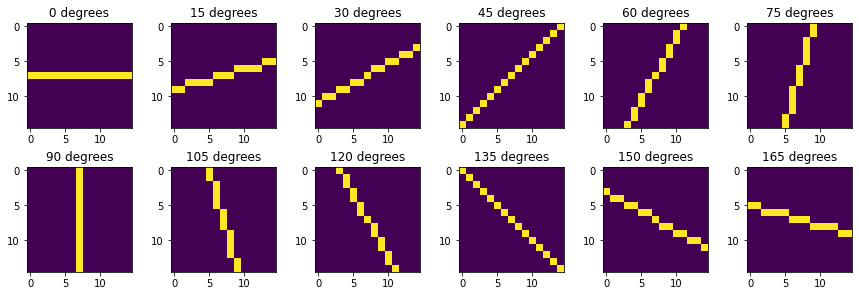

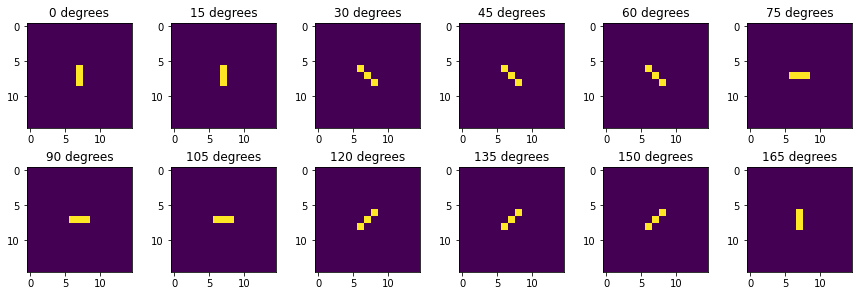

In [5]:
l, l_ort = lines_opt()
#print(l)

##### Verificação do formato e conteúdo das matrizes das linhas

In [6]:
print('Formato da matriz das 12 linhas: ', np.shape(l))
print('Formato da matriz das 12 linhas ortogonais: ', np.shape(l_ort))
print('Pontos da segunda linha (15 graus):')
print(l[1,:,:].transpose())
print('Pontos da segunda linha ortogonal (90+15 graus):')
print(l_ort[1,:,:].transpose())

Formato da matriz das 12 linhas:  (12, 15, 2)
Formato da matriz das 12 linhas ortogonais:  (12, 3, 2)
Pontos da segunda linha (15 graus):
[[ 9  9  8  8  8  8  7  7  7  6  6  6  6  5  5]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]]
Pontos da segunda linha ortogonal (90+15 graus):
[[6 7 8]
 [7 7 7]]


### Cálculo de parâmetros para uma imagem inteira

Função que determina os parâmetros para todos os pontos da imagem passada como argumento, mas somente dentro da retina com base na máscara respetiva que é também passada como argumento. Para o cálculo das features recorre então às coordenadas das linhas previamente calculadas e que seguem como argumento.

In [7]:
def parameters_opt(img_, mask_, sol_,lines, lines_ort):
    
    #constants
    n_lines = 12
    dim = 7
    NL, NC = np.shape(img_)
    print('Image dimensions: ', NL, NC)
    
    #index for the line with greatest intensity: needed for retrieval of correspondent orthogonal
    iline_main = 0
   
    #padding
    img = np.pad(img_, ((dim, dim), (dim, dim)))
    mask = np.pad(mask_, ((dim, dim), (dim, dim)))
    sol = np.pad(sol_, ((dim, dim), (dim, dim)))
    
    #features initialization: should be replaced by simple list, for now they even have the padding shape
    S_test = img.copy()
    I_test = img.copy()
    So_test = img.copy()
    Y_test = img.copy()
    S_test[:] = 0
    So_test[:] = 0
    I_test[:] = 0
    Y_test[:] = 0
        
    #loop trough all the pixels and calculate features
    for i in range(dim, NL+dim):
        for j in range(dim, NC+dim):
            
            #just calculate features for pixels within the retin
            if mask[i,j]!=0:
                
                #retrieve window around pixel for image and mask
                mask_window = mask[i - dim: i + dim + 1, j - dim: j + dim + 1]
                pixel_window = img[i - dim: i + dim + 1, j - dim: j + dim + 1]
                
                #treat border points: fill outside pixels with the remaining's average
                if mask_window[0,0]==0 or mask_window[14,14]==0 or mask_window[0,14]==0 or mask_window[14,0]==0:
                    pixel_window[mask_window == 0] = np.mean(pixel_window[mask_window != 0])
                
                #determine average intensity
                N_ = np.mean(pixel_window)
                
                #retrieve pixel intensity
                I_test[i,j] = img[i,j]
                
                #retrieve solution for that pixel
                Y_test[i,j] = sol[i,j]
                 
                #determine L: greatest intensity level across the lines
                L = np.mean(pixel_window[lines[0,:,0], lines[0,:,1]])
                for i_line in range(1, n_lines):
                    lines_int = pixel_window[lines[i_line,:,0], lines[i_line,:,1]].mean()
                    L_ = L
                    L = max(lines_int, L)
                    if L != L_:
                        iline_main = i_line
                
                #determine S
                S_test[i,j] = L - N_
                
                #retrieve intensity from respective orthogonal line
                Lo = np.mean(pixel_window[lines_ort[iline_main, :, 0], lines_ort[iline_main, :, 1]]) 
                
                #determine So
                So_test[i,j] = Lo - N_
                
    #normalize vector in order to not consider brightness variations
    S_test[mask != 0] = (S_test[mask != 0] - np.mean(S_test[mask != 0]))/np.std(S_test[mask != 0])
    So_test[mask != 0] = (So_test[mask != 0] - np.mean(So_test[mask != 0]))/np.std(So_test[mask != 0])
    I_test[mask != 0] = (I_test[mask != 0] - np.mean(I_test[mask != 0]))/np.std(I_test[mask != 0])
    
    print('Fim')
     
    return S_test, So_test, I_test, Y_test, mask

In [8]:
t1 = time.time()
S_test1_image, So_test1_image, I_test1_image, Y_test1_image, mask_test1_image = parameters_opt(training[0], masks_training[0], sol_training[0], l, l_ort)
t2 = time.time()
print(t2-t1)

Image dimensions:  584 565
Fim
77.39193534851074


##### Verificação do cálculo correto das features

Text(0.5, 1.0, 'Y')

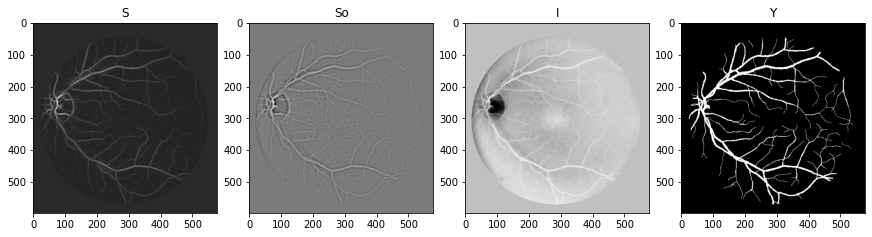

In [9]:
_, axs = plt.subplots(1,4,figsize=[12,12],constrained_layout=True)
axs[0].imshow(S_test1_image, cmap = 'gray')
axs[0].set_title('S')
axs[1].imshow(So_test1_image, cmap = 'gray')
axs[1].set_title('So')
axs[2].imshow(I_test1_image, cmap = 'gray')
axs[2].set_title('I')
axs[3].imshow(Y_test1_image, cmap = 'gray')
axs[3].set_title('Y')

Construir vetor, X e Y, na forma correta

In [10]:
#retrieve only points that are not padding and go from matrix->array
dim = 7
S_test1_f = (S_test1_image[dim:-dim, dim:-dim]).flatten()
So_test1_f = (So_test1_image[dim:-dim, dim:-dim]).flatten()
I_test1_f = (I_test1_image[dim:-dim, dim:-dim]).flatten()
Y_test1_f = (Y_test1_image[dim:-dim, dim:-dim]).flatten()
mask_test1_f = (mask_test1_image[dim:-dim, dim:-dim]).flatten()

#instance....but why?
S_tes1_final = S_test1_f
So_tes1_final = So_test1_f
I_tes1_final = I_test1_f
Y_tes1_final = Y_test1_f
mask_tes1_final = mask_test1_f

#check for initial shapes
print(np.shape(S_tes1_final), np.shape(So_tes1_final),np.shape(I_tes1_final),np.shape(Y_tes1_final))

#how many points should be used for testing: every point but the ones outside retin
length = np.shape(S_tes1_final)[0] - np.shape(I_test1_f[mask_tes1_final==0])[0]
print(length)
print('Pontos iniciais totais: ', np.shape(S_tes1_final)[0])
print('Pontos removidos: ',np.shape(I_test1_f[mask_test1_f==0])[0])
print('Pontos removidos em baixo: ',np.shape(I_tes1_final[mask_tes1_final==0])[0])
print('Pontos aceites no final: ', np.shape(S_tes1_final[mask_tes1_final!=0])[0])

X_image = np.zeros((length, 3), float)
Y_image = np.zeros((length), float)

X_image[:,0] = S_tes1_final[mask_tes1_final!=0]
X_image[:,1] = So_tes1_final[mask_tes1_final!=0]
X_image[:,2] = I_tes1_final[mask_tes1_final!=0]
Y_image[:] = Y_tes1_final[mask_tes1_final!=0]

print(X_image)
print(Y_image)

(329960,) (329960,) (329960,) (329960,)
220382
Pontos iniciais totais:  329960
Pontos removidos:  109578
Pontos removidos em baixo:  109578
Pontos aceites no final:  220382
[[-0.70272494 -0.83586269 -0.70405292]
 [-0.68975737 -0.70395454 -0.53816863]
 [-0.81221067 -2.26158023 -0.75934768]
 ...
 [-0.45751146 -0.31487641  1.2312638 ]
 [-0.46314015 -0.20042615  1.28655857]
 [-0.29875892  0.05652197  1.50773762]]
[0. 0. 0. ... 0. 0. 0.]


####  Fazer o mesmo mas para todas as imagens, de treino e de teste
Desta forma, os testes que se seguirão, nomeadamente, os de cross-validation resumir-se-ão à operação de sorteamento dos pontos com features já calculadas. Após o cálculo, as features são guardadas em disco.

Função que resume as operações de cálculo de features e de reformatação destas para X, Y.

In [7]:
def feature_format(img, mask, sol, l, l_ort, file_name):
    t1 = time.time()
    S_test1_image, So_test1_image, I_test1_image, Y_test1_image, mask_test1_image = parameters_opt(img, mask, sol, l, l_ort)
    t2 = time.time()
    print('Image ', str(i), 'took ',t2-t1, ' seconds.')
    
    #retrieve only points that are not padding and go from matrix->array
    dim = 7
    S_test1_f = (S_test1_image[dim:-dim, dim:-dim]).flatten()
    So_test1_f = (So_test1_image[dim:-dim, dim:-dim]).flatten()
    I_test1_f = (I_test1_image[dim:-dim, dim:-dim]).flatten()
    Y_test1_f = (Y_test1_image[dim:-dim, dim:-dim]).flatten()
    mask_test1_f = (mask_test1_image[dim:-dim, dim:-dim]).flatten()
    
    #instance....but why?
    S_tes1_final = S_test1_f
    So_tes1_final = So_test1_f
    I_tes1_final = I_test1_f
    Y_tes1_final = Y_test1_f
    mask_tes1_final = mask_test1_f
    
    #check for initial shapes
    print(np.shape(S_tes1_final), np.shape(So_tes1_final),np.shape(I_tes1_final),np.shape(Y_tes1_final))
    
    #how many points should be used for testing: every point but the ones outside retin
    length = np.shape(S_tes1_final)[0] - np.shape(I_test1_f[mask_tes1_final==0])[0]
    print(length)
    print('Pontos iniciais totais: ', np.shape(S_tes1_final)[0])
    print('Pontos removidos: ',np.shape(I_test1_f[mask_test1_f==0])[0])
    print('Pontos removidos em baixo: ',np.shape(I_tes1_final[mask_tes1_final==0])[0])
    print('Pontos aceites no final: ', np.shape(S_tes1_final[mask_tes1_final!=0])[0])
    
    X_image = np.zeros((length, 3), float)
    Y_image = np.zeros((length), float)
    
    X_image[:,0] = S_tes1_final[mask_tes1_final!=0]
    X_image[:,1] = So_tes1_final[mask_tes1_final!=0]
    X_image[:,2] = I_tes1_final[mask_tes1_final!=0]
    Y_image[:] = Y_tes1_final[mask_tes1_final!=0]
    
    
    X_filename = file_name + '_X'
    Y_filename = file_name + '_Y'
    dump(X_image,X_filename)
    dump(Y_image,Y_filename)
    
    print('Image ', str(i),' saved.')
    return 

In [9]:
for i in range(20):
    
    clear_output(wait=True)
    #train
    file_name = 'Features/train_' + str(i)
    feature_format(training[i], masks_training[i], sol_training[i], l, l_ort, file_name)
    
    ##test
    #file_name = 'Features/test_' + str(i)
    #feature_format(test[i], mask_test[i], sol1_test[i], l, l_ort, file_name)

Image dimensions:  584 565
Fim
Image  19 took  49.84941029548645  seconds.
(329960,) (329960,) (329960,) (329960,)
220145
Pontos iniciais totais:  329960
Pontos removidos:  109815
Pontos removidos em baixo:  109815
Pontos aceites no final:  220145
Image  19  saved.


In [10]:
for i in range(20):
    
    clear_output(wait=True)
    ##train
    #file_name = 'Features/train_' + str(i)
    #feature_format(training[i], masks_training[i], sol_training[i], l, l_ort, file_name)
    
    #test
    file_name = 'Features/test_' + str(i)
    feature_format(test[i], mask_test[i], sol1_test[i], l, l_ort, file_name)

Image dimensions:  584 565
Fim
Image  19 took  49.328877210617065  seconds.
(329960,) (329960,) (329960,) (329960,)
220457
Pontos iniciais totais:  329960
Pontos removidos:  109503
Pontos removidos em baixo:  109503
Pontos aceites no final:  220457
Image  19  saved.


### Pontos random para treino
Esta secção é dedicada a uma função de cálculo de features alternativa, que é em tudo semelhante à já apresentada (parameters_opt) mas que trata logo do sorteio do numero de pontos requeridos para as imagens de treino.

Função que sorteia os pontos dos quais se vão determinar os pârametros da imagem.

In [7]:
def random_pixels(mask, NL, NC, N):
    li, lj = [], []
    while True:
        i = randint(0, NL)
        j = randint(0, NC)
        
        if mask[i,j]>0:
            li.append(i)
            lj.append(j)
            if len(li)>N:
                break
    return li, lj

Função que determina as features dos N pontos aleatórios para treino da imagem passada como argumento. À semelhança da que calculava para a imagem toda, recebe também a respetiva máscara e solução.

In [8]:
def parameters_opt_random(img_, mask_, sol_, lines, lines_ort, N = 1000):
    
    #constants
    n_lines = 12
    dim = 7
    NL, NC = np.shape(img_)
    #print(NL, NC)
    
    #index for the line with greatest intensity: needed for retrieval of correspondent orthogonal
    iline_main = 0

    #padding
    img = np.pad(img_, ((dim, dim), (dim, dim)))
    mask = np.pad(mask_, ((dim, dim), (dim, dim)))
    sol = np.pad(sol_, ((dim, dim), (dim, dim)))
    
    #features initialization
    S = []
    So = []
    I = []
    Y = []    
    
    #random picking of pixels 
    li, lj = random_pixels(mask, NL + dim*2, NC + dim*2, N)
    
    #counter for control of pixels done
    count = 0    
    
    #loop through all the N pixels
    for j in range(N):
        
            #control print
            #if count%50==0:
            #    print("Hello", str(count), end =" ")
            
            #retrieve window around pixel for image and mask
            mask_window = mask[li[j] - dim: li[j] + dim + 1, lj[j] - dim: lj[j] + dim + 1]
            pixel_window = img[li[j] - dim: li[j] + dim + 1, lj[j] - dim: lj[j] + dim + 1]
            
            #treat border points: fill outside pixels with the remaining's average
            if mask_window[0,0]==0 or mask_window[14,14]==0 or mask_window[0,14]==0 or mask_window[14,0]==0:
                pixel_window[mask_window == 0] = np.mean(pixel_window[mask_window != 0])
            
            #determine average intensity
            N_ = np.mean(pixel_window)
            
            #retrieve pixel intensity
            I.append(img[li[j],lj[j]])
            
            #retrieve pixel solution
            Y.append(sol[li[j],lj[j]])
             
            #determine L: greatest intensity level across the lines
            L = np.mean(pixel_window[lines[0,:,0], lines[0,:,1]])
            for i_line in range(1, n_lines):
                lines_int = pixel_window[lines[i_line,:,0], lines[i_line,:,1]]
                L_ = L
                L = max(np.mean(lines_int), L)
                if L != L_:
                    iline_main = i_line
            #determine S           
            S.append(L - N_)
            
            #retrieve intensity from respective orthogonal line
            Lo = np.mean(pixel_window[lines_ort[iline_main, :, 0], lines_ort[iline_main, :, 1]]) 
            
            #determine So
            So.append(Lo - N_)
            
            count = count + 1
                
    #normalize vector to not consider brightness variations
    S = (S - np.mean(S))/np.std(S)
    So = (So - np.mean(So))/np.std(So)
    I = (I - np.mean(I))/np.std(I)
    
    #print('Fim')
     
    return S, So, I, Y

In [13]:
n = 1000
print(N)
X = np.zeros((N*n, 3), float)
Y = np.zeros((N*n), float)

for i in range(N):
    S_test, So_test, I_test, Y_test = parameters_opt_random(training[i], masks_training[i], sol_training[i], l, l_ort)
    X[i*n:(i+1)*n, 0] = S_test
    X[i*n:(i+1)*n, 1] = So_test
    X[i*n:(i+1)*n, 2] = I_test
    Y[i*n:(i+1)*n] = Y_test

20
584 565
Hello 0 Hello 50 Hello 100 Hello 150 Hello 200 Hello 250 Hello 300 Hello 350 Hello 400 Hello 450 Hello 500 Hello 550 Hello 600 Hello 650 Hello 700 Hello 750 Hello 800 Hello 850 Hello 900 Hello 950 Fim
584 565
Hello 0 Hello 50 Hello 100 Hello 150 Hello 200 Hello 250 Hello 300 Hello 350 Hello 400 Hello 450 Hello 500 Hello 550 Hello 600 Hello 650 Hello 700 Hello 750 Hello 800 Hello 850 Hello 900 Hello 950 Fim
584 565
Hello 0 Hello 50 Hello 100 Hello 150 Hello 200 Hello 250 Hello 300 Hello 350 Hello 400 Hello 450 Hello 500 Hello 550 Hello 600 Hello 650 Hello 700 Hello 750 Hello 800 Hello 850 Hello 900 Hello 950 Fim
584 565
Hello 0 Hello 50 Hello 100 Hello 150 Hello 200 Hello 250 Hello 300 Hello 350 Hello 400 Hello 450 Hello 500 Hello 550 Hello 600 Hello 650 Hello 700 Hello 750 Hello 800 Hello 850 Hello 900 Hello 950 Fim
584 565
Hello 0 Hello 50 Hello 100 Hello 150 Hello 200 Hello 250 Hello 300 Hello 350 Hello 400 Hello 450 Hello 500 Hello 550 Hello 600 Hello 650 Hello 700 Hello 

#### Criar o classificador

In [14]:
clf1 = SVC(kernel='rbf', gamma=0.05)

#### Treinar o classificador

In [15]:
t1 = time.time()
clf1 = clf1.fit(X, Y)
t2 = time.time()
print(t2-t1)

5.470203399658203


#### Prever resultado

In [16]:
t1 = time.time()
y_pred_train = clf1.predict(X_image)
t2 = time.time()
print(t2-t1)

137.09061074256897


#### Calcular taxa de sucesso

In [17]:
print("Taxa de sucesso (Treino): ",
      np.mean(y_pred_train == Y_image) * 100)

from sklearn.metrics import confusion_matrix 

tn, fp, fn, tp = confusion_matrix(Y_image, y_pred_train).ravel()
print((tp+tn)/(tp+tn+fp+fn))
print('tn: ', tn, 'fp: ', 'fp: ', fp, 'fn: ', fn, 'tp: ', tp)

Taxa de sucesso (Treino):  95.3408173081286
0.9534081730812861
tn:  194296 fp:  fp:  1559 fn:  8709 tp:  15818


#### Verificar visualmente resultados

Text(0.5, 1.0, 'Solution from MOI')

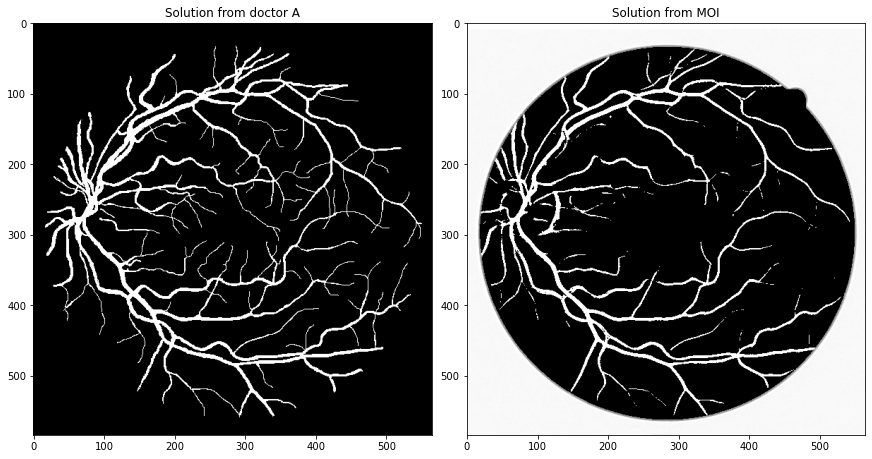

In [21]:
_, axs = plt.subplots(1,2,figsize=[12,12],constrained_layout=True)
axs[0].imshow(sol1_test[0],cmap = 'gray')
axs[0].set_title('Solution from doctor A')

img_copy = test[0].copy()
img_copy[mask_test[0]>0] =y_pred_train 
axs[1].imshow(img_copy,cmap = 'gray')
axs[1].set_title('Solution from MOI')

(584, 565, 3)
[[1.85333333 1.30666667 2.06666667 ... 1.39111111 1.53777778 1.13333333]
 [2.42222222 2.76       2.37333333 ... 1.52       0.80444444 0.35555556]
 [5.48888889 4.23555556 4.26666667 ... 0.46666667 0.10666667 0.62222222]
 ...
 [2.81777778 3.03111111 1.88888889 ... 2.55111111 2.71555556 2.79555556]
 [2.13333333 1.95111111 0.76       ... 2.63555556 2.96888889 2.84      ]
 [1.78666667 0.90222222 0.12444444 ... 2.81777778 2.61333333 2.34222222]]
[[ 75.91278059  68.21511199  78.91674882 ...  81.04455965  80.16840225
   87.86607085]
 [ 83.92336254  88.67964558  83.23495316 ...  84.48660659  82.35879575
   88.11640154]
 [127.10540591 109.45709253 109.89517123 ...  78.66641813  83.48528384
   86.36408673]
 ...
 [ 81.42005568  76.41344196  70.34292282 ...  66.71312787  62.26975819
   52.88235746]
 [ 69.52934809  66.27504917  66.02471848 ...  74.91145784  67.5267026
   67.21378924]
 [ 81.42005568  82.10846507  71.59457625 ...  72.34556831  72.22040296
   71.53199358]]


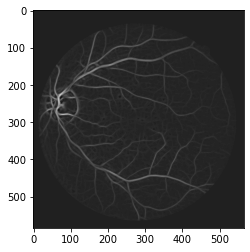

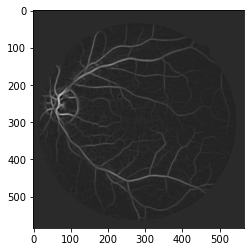

In [36]:
tiago_train1 = load('car_S_So_I_train1')
print(np.shape(tiago_train1))
plt.imshow(tiago_train1[:,:,0], cmap = 'gray')
plt.figure()
plt.imshow(S_test1_image[dim:-dim,dim:-dim], cmap = 'gray')

np.allclose((tiago_train1[:,:,0])[masks_training[0]>0], (S_test1_image[dim:-dim,dim:-dim])[masks_training[0]>0], 1)

print(tiago_train1[200:300,200:300,0])
print((S_test1_image[200+dim:300-dim,200+dim:300-dim] - np.min(S_test1_image[200:300,200:300]))/np.max(S_test1_image[200:300,200:300])*255)

### Cross-validation

Nesta secção tornou-se a criação e treino de classificadores expedita de forma a poder formar os batches e fazer a sua rotação, experimentando diferentes hiperparâmetros gamma e c, com o objetivo de determinar o par de valores para os quais se obtém a melhor acc.

Numa primeira fase, faz-se o load das features das imagens de treino previamente calculadas. Estas já têm o formato correto para fazer o treino do classificador e a comparação da previsão.

In [14]:
file_name_ftrain = 'Features/train_'
file_name_ftrain = 'Features/train_'
file_name_ftest = 'Features/test_'
file_name_stest = 'Features/test_'


features_train = []
solutions_train = []
features_test = []
solutions_test = []

N = 20

for i in range(N):
    file_name_ftrain_i = file_name_ftrain + str(i) + '_X'
    file_name_strain_i = file_name_ftrain + str(i) + '_Y'
    features_train.append(load(file_name_ftrain_i))
    solutions_train.append(load(file_name_strain_i))
    
    file_name_ftest_i = file_name_ftest + str(i) + '_X'
    file_name_stest_i = file_name_ftest + str(i) + '_Y'
    features_test.append(load(file_name_ftest_i))
    solutions_test.append(load(file_name_stest_i))

Confirmação do carregamento pelo formato das features carregadas.

In [15]:
print(np.shape(features_train[1]))
print(np.shape(solutions_train[1]))

(220685, 3)
(220685,)


Em segundo lugar, faz-se o sorteio dos 20000 pontos que serão divididos por 5 batches. Features de uma mesma imagem não deverão estar em batches diferentes. Então, sendo 1000 pontos tirados de cada imagem, em cada batch estarão features de 4 imagens.

In [9]:
n = 1000
X = np.zeros((N*n, 3), float)
Y = np.zeros((N*n), float)

for i in range(N):
    S_test, So_test, I_test, Y_test = parameters_opt_random(training[i], masks_training[i], sol_training[i], l, l_ort)
    X[i*n:(i+1)*n, 0] = S_test
    X[i*n:(i+1)*n, 1] = So_test
    X[i*n:(i+1)*n, 2] = I_test
    Y[i*n:(i+1)*n] = Y_test

Definem-se os limites dos 5 k-folds (para já estão por ordem de imagem).

In [23]:
indexes = [0, 20000/5-1, 20000/5*2-1,20000/5*3-1,20000/5*4-1,20000/5*5-1]
print(indexes)

[0, 3999.0, 7999.0, 11999.0, 15999.0, 19999.0]


Realizam-se então as rotações para os valores de gamma e c a serem experimentados. Este tomam nesta fase inicial um intervalo grande de forma a determinar onde se localizará o máximo de acc. Para cada par gamma/c é devolvida a média da acc das 5 rotações.

In [10]:
def train_validate(t, t_sol, v, v_sol, g, c):
    #print('hello')
    t1 = time.time()

    clf1 = SVC(kernel='rbf', C = c, gamma = g)
    clf1 = clf1.fit(t, t_sol)
    y_pred_train = clf1.predict(v)
    acc = np.mean(y_pred_train == v_sol) * 100
    
    t2 = time.time()
    #print('Time ', t2-t1)
    #print(acc)
    return acc 

In [11]:
def pair_5rotations(gamma, c, X, Y):
    
    acc_average = 0.
    ind = [0, int(20000/5), int(20000/5*2),int(20000/5*3),int(20000/5*4),int(20000/5*5)]
    
    for i in range(5):
        acc_average += train_validate(X[ind[0]:ind[4]], Y[ind[0]:ind[4]], X[ind[4]:ind[5]], Y[ind[4]:ind[5]], gamma, c)
        #print(X[ind[0]:ind[4]], X[ind[4]:ind[5]])
        X = np.roll(X, 4000, axis = 0)
        Y = np.roll(Y, 4000, axis = 0)
    
    
    return (acc_average/5.)

In [41]:
def hyperparameter_sweep(gamma_range, c_range, X, Y, n):
    
    gamma = np.linspace(gamma_range[0], gamma_range[1], n)
    c = np.linspace(c_range[0], c_range[1], n)
    
    acc_grid = np.zeros((n,n), float)
    i = -1
    
    gammas = []
    cs = []
    accs = []
    
    for gamma_i in gamma:
        i += 1
        j = -1
        #gamma_i = 0.05
        for c_i in c:
            #c_i = 1
            j += 1
            acc_grid[i, j] = pair_5rotations(gamma_i, c_i, X, Y)
            print('gamma ', gamma_i, 'c ', c_i, ': ', acc_grid[i, j])
            gammas.append(gamma_i)
            cs.append(c_i)
            accs.append(acc_grid[i,j])
            
            
    plt.imshow(acc_grid)
    return gamma, c, acc_grid

gamma  0.03 c  0.1 :  93.7
gamma  0.03 c  0.575 :  93.73999999999998
gamma  0.03 c  1.05 :  93.735
gamma  0.03 c  1.525 :  93.74499999999998
gamma  0.03 c  2.0 :  93.72999999999999
gamma  0.27249999999999996 c  0.1 :  93.74499999999999
gamma  0.27249999999999996 c  0.575 :  93.805
gamma  0.27249999999999996 c  1.05 :  93.81
gamma  0.27249999999999996 c  1.525 :  93.815
gamma  0.27249999999999996 c  2.0 :  93.815
gamma  0.515 c  0.1 :  93.69500000000001
gamma  0.515 c  0.575 :  93.81
gamma  0.515 c  1.05 :  93.83500000000001
gamma  0.515 c  1.525 :  93.82
gamma  0.515 c  2.0 :  93.815
gamma  0.7575000000000001 c  0.1 :  93.66999999999999
gamma  0.7575000000000001 c  0.575 :  93.77000000000001
gamma  0.7575000000000001 c  1.05 :  93.79
gamma  0.7575000000000001 c  1.525 :  93.79
gamma  0.7575000000000001 c  2.0 :  93.775
gamma  1.0 c  0.1 :  93.635
gamma  1.0 c  0.575 :  93.73
gamma  1.0 c  1.05 :  93.74000000000001
gamma  1.0 c  1.525 :  93.765
gamma  1.0 c  2.0 :  93.72999999999999


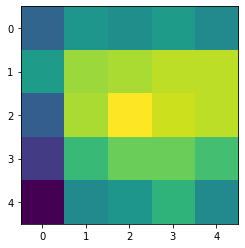

In [44]:
gammas, cs, acc_grid = hyperparameter_sweep([0.03,1], [0.1,2.0], X, Y, 5)

In [40]:
gammas_, cs_, acc_grid_ = hyperparameter_sweep([-3,1], [0.01,0.9], X, Y, 5)

gamma  0.001 c  0.01 :  87.17999999999999
gamma  0.001 c  0.2325 :  92.335
gamma  0.001 c  0.455 :  92.925
gamma  0.001 c  0.6775 :  93.14500000000001
gamma  0.001 c  0.9 :  93.235
gamma  0.01 c  0.01 :  91.17999999999999
gamma  0.01 c  0.2325 :  93.61499999999998
gamma  0.01 c  0.455 :  93.67999999999999
gamma  0.01 c  0.6775 :  93.715
gamma  0.01 c  0.9 :  93.73
gamma  0.1 c  0.01 :  93.39
gamma  0.1 c  0.2325 :  93.74499999999999
gamma  0.1 c  0.455 :  93.74499999999999
gamma  0.1 c  0.6775 :  93.74999999999999
gamma  0.1 c  0.9 :  93.725


KeyboardInterrupt: 

### Otimização por evolução da variação

Com o algoritmo que se segue é feita a tentativa de se otimizar se forma mais rigorosa a expedita o tunning dos hiperparâmetros. Isto é realizado recorrendo às derivadas parciais da accuracy relativamente a c e a gamma. Face ao sweeping dos hiperparâmetros, é esperado um hiperplano que terá um máximo para um certo par de c e gamma. É elaborado um algoritmo iterativo que avalia a evolução da accuracy de acordo à variação dos parâmetros, garantindo a evolução no sentido certo tendo em conta pontos do hiperplano previamente calculados.

In [22]:
def gradient(x_lower, x_higher, y_lower, y_higher):
    
    num = y_higher - y_lower
    den = x_higher - x_lower
    
    grad = num/den
    
    return grad

In [ ]:
def hyperparameter_optimization(gammas, cs, accs, ind_gamma0, ind_c0, X, Y, max_iter):
    
    #current values with maximum accuracy
    acc_cur = 0.
    gamma_cur = gammas[ind_gamma0]
    c_cur = cs[ind_c0]
    
    
    #hyperparameters to be used in present iteration: starts with initial prediction
    gamma = gammas[ind_gamma0]
    c = cs[ind_c0]
    
    #steps for increasing/decreasing c and gamma according to their influence on the previous iteration
    c_step0 = 0.05
    gamma_step0 = 0.05
    
    #scales for the steps in accordance with gradient evolution: for small gradients, we must be near the maximum->reduce step
    gamma_scale = 0.5
    c_scale = 0.5
    
    #current steps
    c_step = c_step0
    gamma_step = gamma_step0
    
    #gradient calculation: neighbour points for gamma and c partial derivatives calculation
    gamma_lower = [gammas[ind_gamma0 - 1], accs[ind_gamma0 - 1, ind_c0]]
    gamma_higher = [gammas[ind_gamma0 + 1], accs[ind_gamma0 + 1, ind_c0]]
    c_lower = [cs[ind_c0 - 1], accs[ind_gamma0, ind_c0 - 1]]
    c_higher = [cs[ind_c0 + 1], accs[ind_gamma0, ind_c0 + 1]]
    
    
    for i in range(max_iter):
        
        print('gamma: ', gamma, ' c: ', c)
        #calculate gradient 
        acc_i = pair_5rotations(gamma, c, X, Y)  
                    
        print('accuracy: ', acc_i)
                    
        #compare results
        if acc_cur < acc_i:
                    
            #update neighbours
            if gamma_step>0:
                gamma_lower = [gamma_cur, acc_cur]
            else: 
                gamma_higher = [gamma_cur, acc_cur]
                    
            if c_step>0:
                c_lower = [c_cur, acc_cur]
            else: 
                c_higher = [c_cur, acc_cur]
                    
            acc_cur = acc_i
            gamma_cur = gamma
            c_cur = c
            
                    
            
            
        else:
            #decrease step: but was there a hyperparameter, gamma or c, that conducted the evolution worse...?could be evaluated by new each parameter gradient maybe
            if c_step>gamma_step:
                c_step *= c_scale
            else:
                gamma_step *= gamma_scale
            
                    
            #update neighbours
            if gamma_step>0:
                gamma_higher = [gamma, acc_i]
            else: 
                gamma_lower = [gamma, acc_i]
                    
            if c_step>0:
                c_higher = [c, acc_i]
            else: 
                c_lower = [c, acc_i]
            
            
        #access by the gradient to each side one should vary gamma and c
        grad_gamma = gradient(gamma_lower[0], gamma_higher[0], gamma_lower[1], gamma_higher[1])
        grad_c = gradient(c_lower[0], c_higher[0], c_lower[1], c_higher[1])
                    
        #update evolution direction according to new gradient        
        gamma_step *= grad_gamma/abs(grad_gamma)
        c_step *= grad_c/abs(grad_c)
        
        #update to new attempt of hyperparameters
        gamma = gamma_cur + gamma_step
        c = c_cur + c_step
        
    return 

In [ ]:
hyperparameter_optimization(gammas, cs, acc_grid, 2, 2, X, Y, 10)